# Extract info about queries with secondary mappings

## Create table

In [3]:
import pysam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def sec_query_list(sam_file):
    secondary = []
    with pysam.AlignmentFile(sam_file) as af:
        for read in af:
            if read.is_secondary:
                secondary.append(read.query_name)
    return np.unique(secondary)

In [5]:
def get_real_query_start_end(sam_start, sam_end, query_length, cigar_tuples, forward):    
    hc = 0 if cigar_tuples[0][0] != 5 else cigar_tuples[0][1]
    if forward:
        return sam_start + hc, sam_end + hc
    else:
        return query_length - hc - sam_start, query_length - hc - sam_end

In [14]:
sam_file = "../results/reads.sorted.bam"
csv_file = "../results/sec_reads_info.csv"

secondary = sec_query_list(sam_file)

df = []
with pysam.AlignmentFile(sam_file) as af:
    for read in af:
            if read.query_name in secondary:
                mapping_type = 'primary'
                if read.is_secondary:
                    mapping_type = 'secondary'
                elif read.is_supplementary:
                    mapping_type = 'supplementary'
                query_start, query_end = get_real_query_start_end(read.query_alignment_start, read.query_alignment_end,
                                                                  read.infer_read_length(), read.cigartuples, read.is_forward)
                df.append({
                    "query_name" : read.query_name,
                    "is_forward" : read.is_forward,
                    "type" : mapping_type,
                    "ref_start" : read.reference_start,
                    "ref_end" : read.reference_end,
                    "query_start" : query_start,
                    "query_end" : query_end,
                    "alignment_length" : read.query_alignment_length,
                    "query_length" : read.infer_read_length(),
                    "matches" : read.get_cigar_stats()[0][0],
                    "insertions" : read.get_cigar_stats()[0][1],
                    "deletions" : read.get_cigar_stats()[0][2],
                    "soft_clips" : read.get_cigar_stats()[0][4],
                    "hard_clips" : read.get_cigar_stats()[0][5],                
                })
df = pd.DataFrame(df)
df.to_csv(csv_file)
df

,query_name,is_forward,type,ref_start,ref_end,query_start,query_end,alignment_length,query_length,matches,insertions,deletions,soft_clips,hard_clips
0,8c07acdd-1c29-443b-b489-e72a0ed29db1,True,primary,117219,121479,0,4185,4185,4186,4106,79,154,1,0
1,72abf396-02ce-408c-a5ea-993cc5b3327a,True,secondary,117853,121542,98,3745,3647,4192,3618,29,71,545,0
2,78236138-9f23-4025-8d86-14f3d8df6730,True,secondary,117853,121419,355,3904,3549,3904,3513,36,53,355,0
3,8ebe9c2f-dc84-4ab5-ada6-69d74a85149a,True,primary,117904,120112,0,2182,2182,2182,2136,46,72,0,0
4,f097b5e0-f15d-42a3-9ee5-a0d32d636ae8,False,secondary,118037,120026,1967,0,1967,1968,1944,23,45,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,0fe78966-cb29-41d9-a099-76616ea5e4e4,True,secondary,4584745,4585113,0,360,360,361,358,2,10,1,0
1161,0cb67240-f14a-4280-98f7-10d57f72b9a4,False,secondary,4584969,4585382,400,0,400,400,397,3,16,0,0
1162,c5845bde-f1e5-41ae-84c6-16da5b0526bf,True,secondary,4585016,4585364,0,345,345,346,338,7,10,1,0
1163,1e05306d-79b9-4621-820c-149c622535b1,False,secondary,4585023,4585529,493,0,493,493,486,7,20,0,0


## Create list of dicts for each query

In [7]:
query_ids = []
for s in secondary:
    prim = 0
    sec = []
    supp = []
    for row in df.itertuples():
        if row.query_name == s:
            if row.type == "secondary":
                sec.append(row.ref_start)
            elif row.type == "supplementary":
                supp.append(row.ref_start)
            else:
                prim = row.ref_start
    query_ids.append({
        "query_name" : s,
        "primary" : prim,
        "secondary" : sec,
        "supplementary" : supp
    })

## Plot primary vs secondary starts

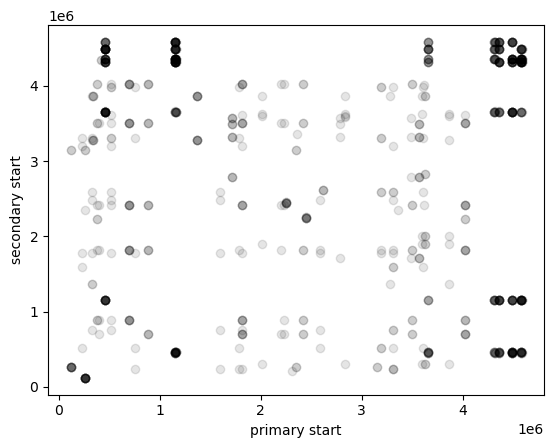

In [10]:
for q in query_ids:
    for s in q["secondary"]:
        plt.scatter(q["primary"],s,c="k", alpha=0.1)
plt.xlabel("primary start")
plt.ylabel("secondary start")
plt.savefig("../results/figures/extract_sec_secondary.png")
plt.show()

- 

## Plot primary vs supplementary starts

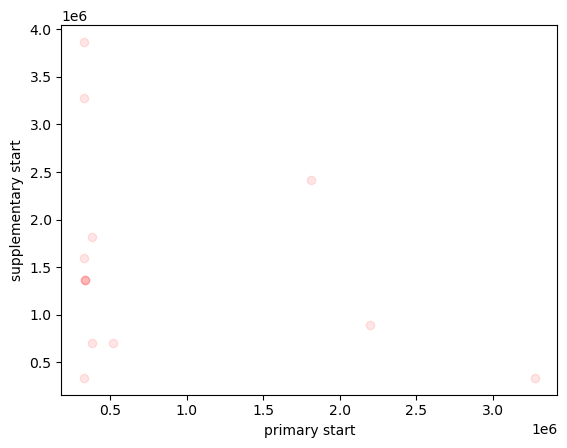

In [13]:
for q in query_ids:
    for s in q["supplementary"]:
        plt.scatter(q["primary"],s,c=color,alpha=0.1)
plt.xlabel("primary start")
plt.ylabel("supplementary start")
plt.savefig("../results/figures/extract_sec_supplementary.png")
plt.show()